In [1]:
import tensorflow as tf
from tensorflow import keras
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt 

In [2]:
model = keras.applications.VGG16(weights='imagenet',include_top=True)

553467096/553467096 [==============================] - 4s 0us/step


In [3]:
!wget https://kot-pes.com/wp-content/uploads/2019/02/post_5c606e629f934.jpg

--2023-04-06 16:10:23--  https://kot-pes.com/wp-content/uploads/2019/02/post_5c606e629f934.jpg
Resolving kot-pes.com (kot-pes.com)... 116.202.193.218
Connecting to kot-pes.com (kot-pes.com)|116.202.193.218|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 161127 (157K) [image/jpeg]
Saving to: ‘post_5c606e629f934.jpg’

post_5c606e629f934. 100%[===================>] 157.35K   685KB/s    in 0.2s    

2023-04-06 16:10:24 (685 KB/s) - ‘post_5c606e629f934.jpg’ saved [161127/161127]



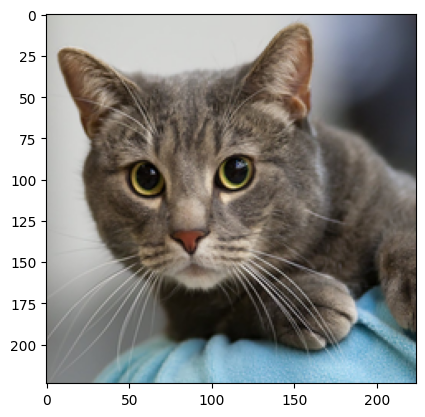

In [11]:
img = np.array(Image.open('post_5c606e629f934.jpg').resize((300,224),Image.LANCZOS))[:,20:224+20]
plt.imshow(img)

In [32]:
im = np.expand_dims(keras.applications.vgg16.preprocess_input(img),0)
res = model.predict(im)
np.argsort(res)[0][-5:][::-1]

1/1 [==============================] - 0s 19ms/step


array([281, 285, 282, 457, 287])

In [28]:
keras.applications.vgg16.decode_predictions(res)

[[('n02123045', 'tabby', 0.48037082),
  ('n02124075', 'Egyptian_cat', 0.26514202),
  ('n02123159', 'tiger_cat', 0.06812516),
  ('n02883205', 'bow_tie', 0.034605768),
  ('n02127052', 'lynx', 0.011297573)]]

In [30]:
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [33]:
vmodel = keras.models.Model(model.input,model.get_layer('block1_conv1').output)
res = vmodel.predict(im)

1/1 [==============================] - 0s 108ms/step


In [34]:
res.shape

(1, 224, 224, 64)

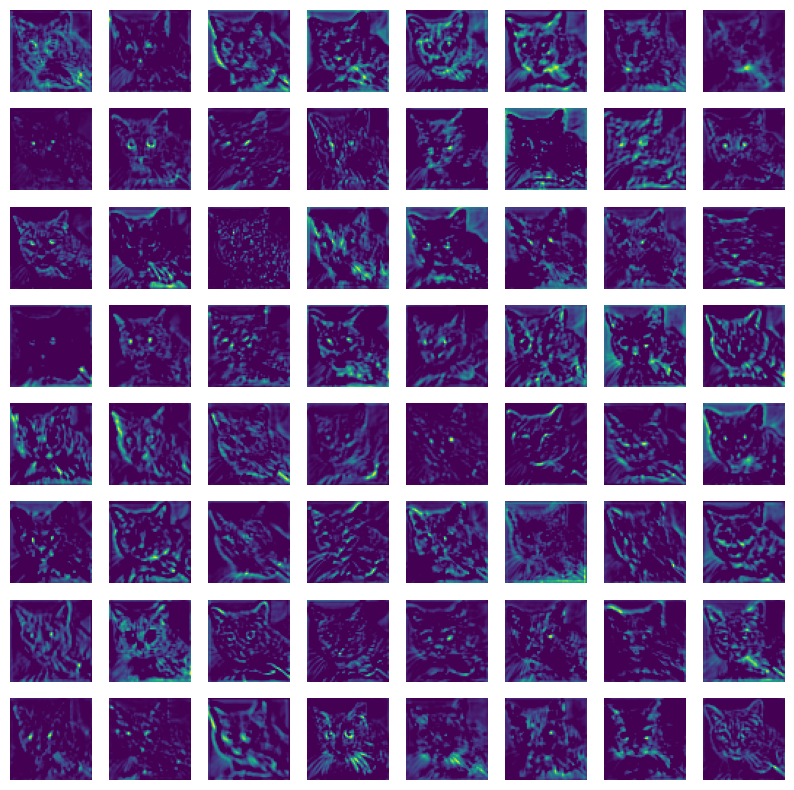

In [41]:
fig,ax = plt.subplots(8,8,figsize=(10,10))
vmin, vmax = np.min(res), np.max(res) 
for i in range(8):
  for j in range(8):
    ax[i,j].imshow(res[0,:,:,i*8+j])#,vmin=vmin,vmax=vmax)
    ax[i,j].axis('off')

1/1 [==============================] - 0s 76ms/step


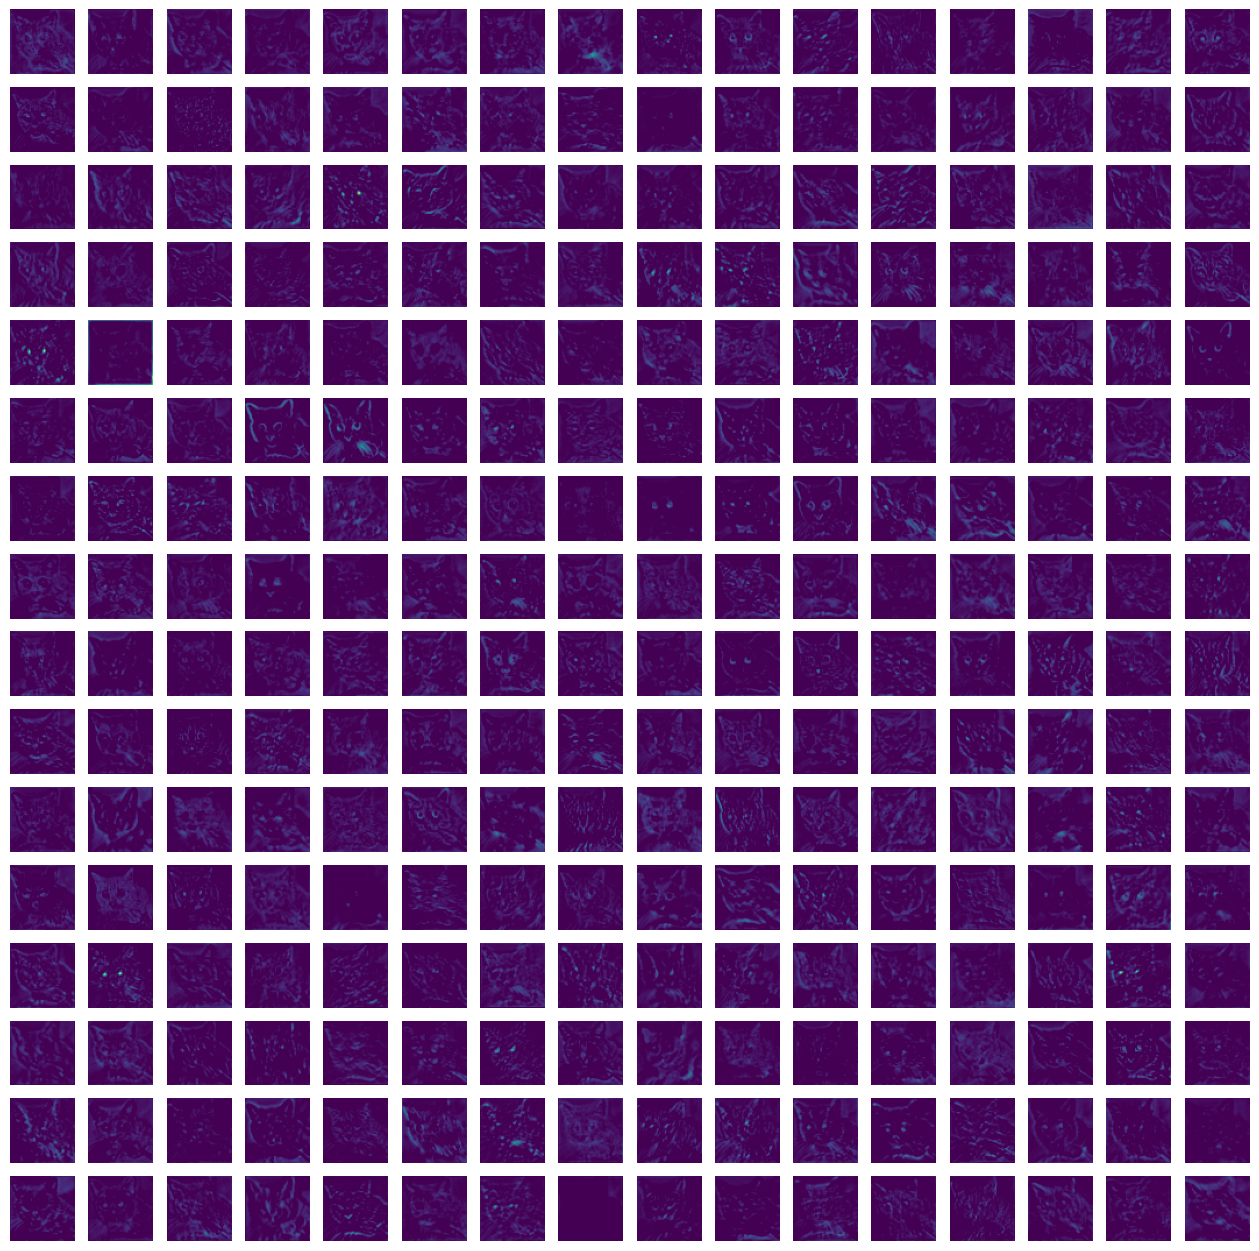

In [39]:
vmodel = keras.models.Model(model.input,model.get_layer('block3_conv2').output)
res = vmodel.predict(im)
vmin, vmax = np.min(res), np.max(res) 
fig,ax = plt.subplots(16,16,figsize=(16,16))
for i in range(16):
  for j in range(16):
    ax[i,j].imshow(res[0,:,:,i*16+j],vmin=vmin,vmax=vmax)
    ax[i,j].axis('off')

1/1 [==============================] - 0s 248ms/step


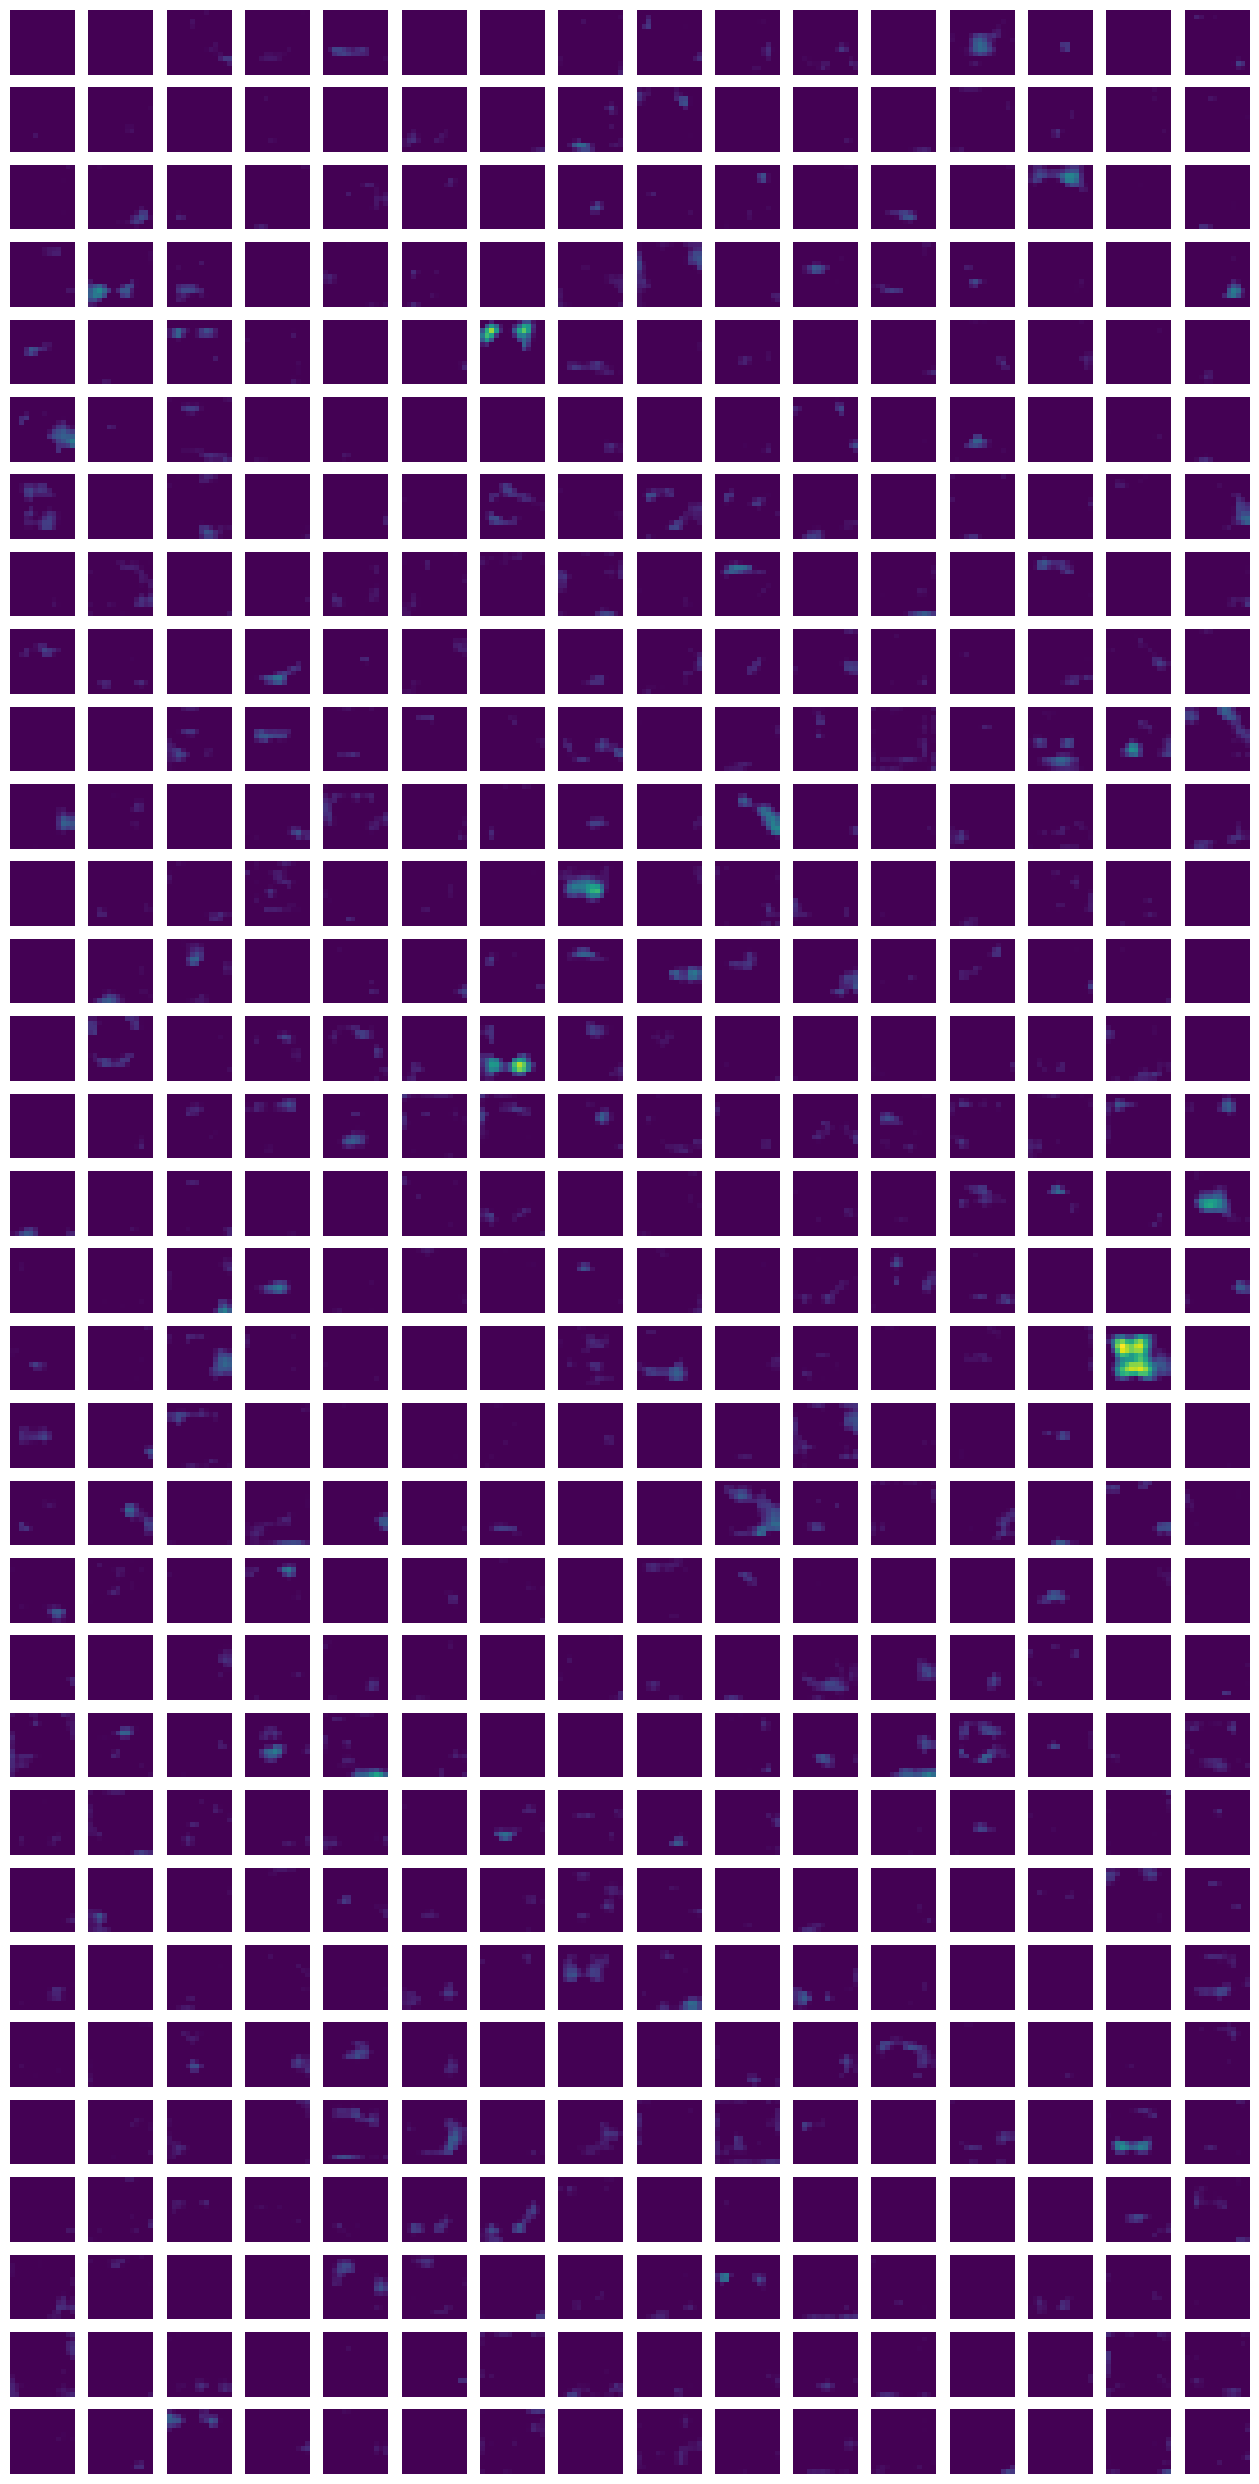

In [44]:
vmodel = keras.models.Model(model.input,model.get_layer('block5_conv3').output)
res = vmodel.predict(im)
vmin, vmax = np.min(res), np.max(res) 
fig,ax = plt.subplots(32,16,figsize=(16,32))
for i in range(32):
  for j in range(16):
    ax[i,j].imshow(res[0,:,:,i*16+j],vmin=vmin,vmax=vmax)
    ax[i,j].axis('off')

## Ideal Cat

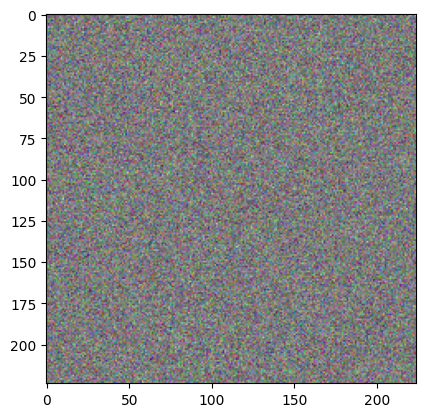

In [52]:
x = tf.Variable(tf.random.normal((1,224,224,3)))

def normalize(img):
    return (img-tf.reduce_min(img))/(tf.reduce_max(img)-tf.reduce_min(img))

plt.imshow(normalize(x[0]))

Predicted class: 669 (mosquito net)
Probability of predicted class = 0.048640176653862


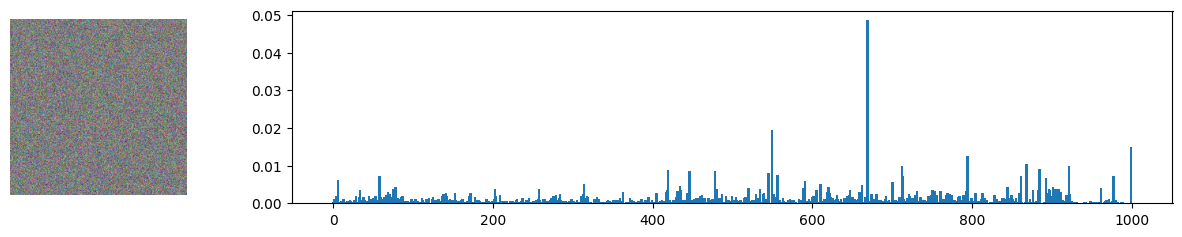

In [47]:
import json 

classes = json.loads(open('imagenet_classes.json','r').read())

def plot_result(x):
    res = model(x)[0]
    cls = tf.argmax(res)
    print(f"Predicted class: {cls} ({classes[cls]})")
    print(f"Probability of predicted class = {res[cls]}")
    fig,ax = plt.subplots(1,2,figsize=(15,2.5),gridspec_kw = { "width_ratios" : [1,5]} )
    ax[0].imshow(normalize(x[0]))
    ax[0].axis('off')
    ax[1].bar(range(1000),res,width=3)
    plt.show()

plot_result(x)

Epoch: 900, loss: 0.18433262407779694


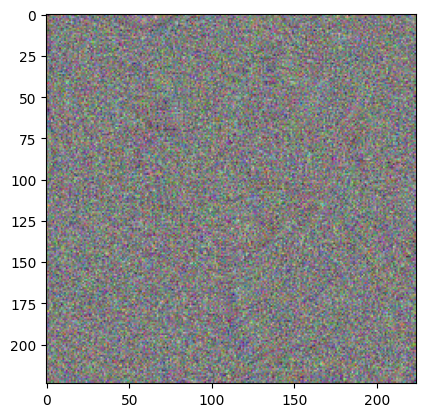

In [50]:
from IPython.display import clear_output

target = [284] # Siamese cat

def cross_entropy_loss(target,res):
    return tf.reduce_mean(keras.metrics.sparse_categorical_crossentropy(target,res))

def optimize(x,target,epochs=1000,show_every=None,loss_fn=cross_entropy_loss, eta=1.0):
    if show_every is None:
        show_every = epochs // 10
    for i in range(epochs):
        with tf.GradientTape() as t:
            res = model(x)
            loss = loss_fn(target,res)
            grads = t.gradient(loss,x)
            x.assign_sub(eta*grads)
            if i%show_every == 0:
                clear_output(wait=True)
                print(f"Epoch: {i}, loss: {loss}")
                plt.imshow(normalize(x[0]))
                plt.show()

optimize(x,target)

Predicted class: 284 (Siamese cat, Siamese)
Probability of predicted class = 0.8409451842308044


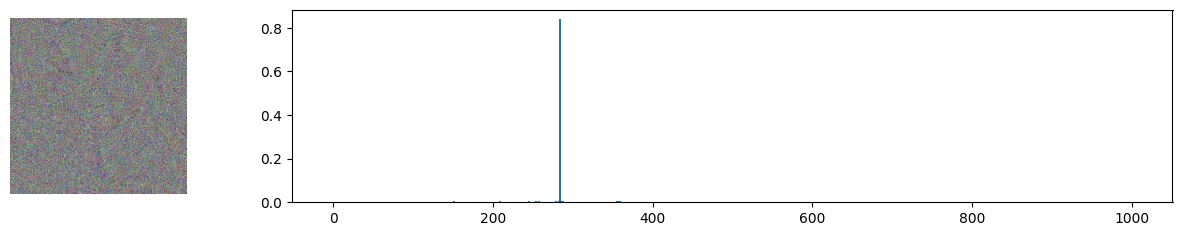

In [51]:
plot_result(x)

Epoch: 900, loss: [30.086075]


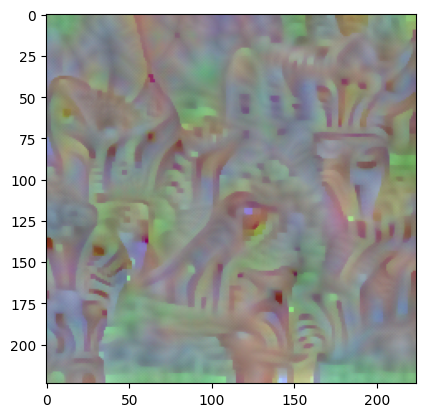

In [61]:
x = tf.Variable(tf.random.normal((1,224,224,3)))

def total_loss(target,res):
    return 10*tf.reduce_mean(keras.metrics.sparse_categorical_crossentropy(target,res)) + \
           0.005*tf.image.total_variation(x,res)

optimize(x,[340],loss_fn=total_loss)

Predicted class: 284 (Siamese cat, Siamese)
Probability of predicted class = 0.40732574462890625


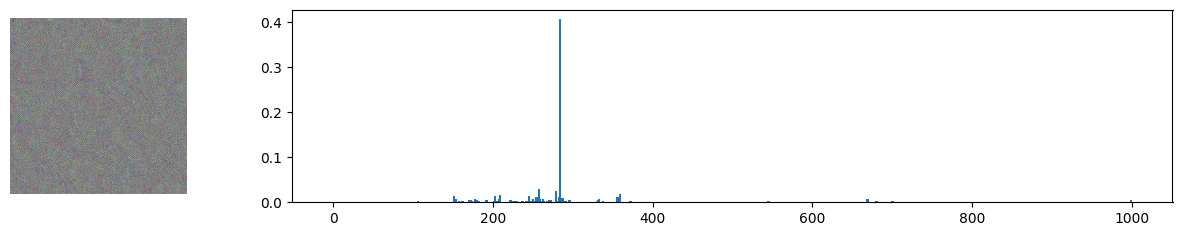

In [54]:
plot_result(x)

In [60]:
[ x for x in enumerate(classes) if "zebra" in x[1]]

[(340, 'zebra')]